In [1]:
# To deal with Data Imbalance Problem
# Using Oversampling

In [2]:
import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from matplotlib.pyplot import rcParams
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

In [3]:
# Data Reading

cust = pd.read_csv('./Customer.csv', encoding = 'cp949')
df = pd.read_csv('./Claim.csv', encoding = 'cp949')

In [4]:
# Data Concatenate

data_add = cust[['CUST_ID', 'SIU_CUST_YN']]
data_add['SIU_CUST_YN'] = data_add.SIU_CUST_YN.map({'Y' : 1, 'N' : 0})
ID_SIU_dict = data_add.set_index('CUST_ID').T.to_dict('list')


target = []
for i in range(df.shape[0]):
    ID = df.CUST_ID[i]
    target.append(ID_SIU_dict[ID])
df['target'] = np.array(target)

/Users/jangbaekwon/opt/anaconda3/envs/jbk/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [5]:
# Drop the some of columns not necessary and NaN

df = df.dropna()
df = df.drop(['CUST_ID'], axis = 1)
df = df.drop(['POLY_NO'], axis = 1)
df = df.drop(['ACCI_OCCP_GRP2'], axis = 1)
df = df.drop(['CNTT_RECP_SQNO'], axis = 1)
df = df.drop(['RECP_DATE'], axis = 1) 
df = df.drop(['ORIG_RESN_DATE'], axis = 1)
df = df.drop(['RESN_DATE'], axis = 1)
df = df.drop(['DSAS_NAME'], axis = 1)
df = df.drop(['RESL_NM1'], axis = 1)
df = df.drop(['PAYM_DATE'], axis = 1)

In [6]:
# EDA
# To Check the Relevance btw Features and target, made function

def cal_percentage_1(k):
  print(df.keys()[k])
  
  value = []

  rank = []

  for i in range(len(df[df.keys()[k]].value_counts())):
    value.append(df[df.keys()[k]].value_counts().index[i])
  
  for j in range(len(value)):
    sum = 0
    for i in range(df.shape[0]):
      if df[df.keys()[k]].to_numpy()[i] == value[j]:
        if df['target'].to_numpy()[i] == 1:
          sum += 1
    rank.append([value[j], round(sum / df['target'].value_counts()[1], 3)])
    #print(value[j], round(sum / df['target'].value_counts()[1], 3))
  print(sorted(rank, key = lambda rank: rank[1], reverse = True), '\n', '\n')

In [ ]:
for i in range(df.shape[1]):
    cal_percentage_1(i)

In [7]:
# Delete Additinal Columns which are Ambiguous against the target

df = df.drop(['CAUS_CODE'], axis = 1)
df = df.drop(['RESL_CD1'], axis = 1)
df = df.drop(['HOSP_CODE'], axis = 1)
df = df.drop(['DMND_AMT'], axis = 1)
df = df.drop(['PAYM_AMT'], axis = 1)
df = df.drop(['PMMI_DLNG_YN'], axis = 1)
df = df.drop(['SELF_CHAM'], axis = 1)
df = df.drop(['NON_PAY'], axis = 1)
df = df.drop(['PATT_CHRG_TOTA'], axis = 1)
df = df.drop(['NON_PAY_RATIO'], axis = 1)
df = df.drop(['HOSP_OTPA_STDT'], axis = 1)
df = df.drop(['HOSP_OTPA_ENDT'], axis = 1)
df = df.drop(['DCAF_CMPS_XCPA'], axis = 1)

In [8]:
# Check the Balance of the Target
# There's Data Imbalance

df['target'].value_counts()

0.0    6443
1.0     340
Name: target, dtype: int64

In [9]:
# df to Split X and Y

x = df.iloc[:, :16]
y = df['target']

x = pd.get_dummies(x)

0.9491525423728814


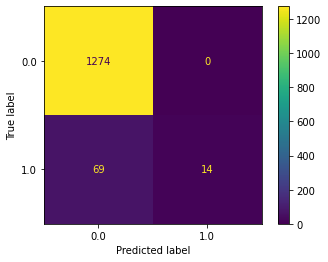

accuracy 0.9491525423728814
precision 1.0
recall 0.1686746987951807
f1 0.288659793814433


In [10]:
# Modeling (gbtree) and Check the Score
# From the Result, the Low Score of Recall is Shown due to Data Imbalance

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True)

model = XGBClassifier(booster = 'gbtree', objective = 'binary:logistic')
model.fit(x_train, y_train)
pred = model.predict(x_test)

matches = (pred == y_test)
print(matches.sum()/len(matches))

rcParams['figure.figsize'] = 7, 7
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.show()

print('accuracy', accuracy_score(y_test, pred)) 
print('precision', precision_score(y_test, pred)) 
print('recall', recall_score(y_test, pred))
print('f1', f1_score(y_test, pred))

0.871039056742815


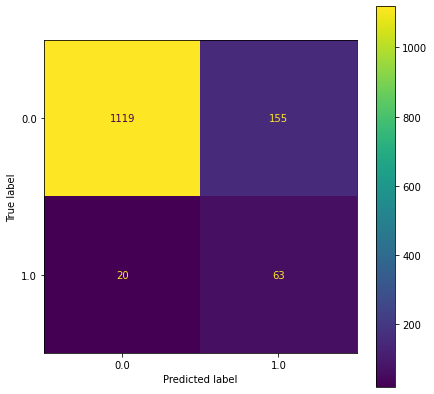

accuracy 0.871039056742815
precision 0.2889908256880734
recall 0.7590361445783133
f1 0.41860465116279066


In [11]:
# Oversampling can Solve the Data Imbalance Problem
# The Result Shows much better Score of the Recall

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state = 0)

x_resampled, y_resampled = ros.fit_resample(x, y)

model = XGBClassifier(booster = 'gbtree', objective = 'binary:logistic')
model.fit(x_resampled, y_resampled)
pred = model.predict(x_test)

matches = (pred == y_test)
print(matches.sum()/len(matches))

rcParams['figure.figsize'] = 7, 7
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.show()

print('accuracy', accuracy_score(y_test, pred)) 
print('precision', precision_score(y_test, pred))
print('recall', recall_score(y_test, pred))
print('f1', f1_score(y_test, pred))